In [1]:
import numpy as np
from scipy.sparse import csr_matrix
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
import scipy.sparse

In [3]:
with open("train.dat", "r", encoding="utf8") as file:
    lines = file.readlines()  

In [4]:
docs = [line.split() for line in lines]

In [5]:
def convert_to_csr_matrix(docs):
    rows = [] #doc number
    cols = [] #term indexes
    data = [] # frquency values
    for docno, doc in enumerate(docs):
#         print(doc)
        for idx in range(int(len(doc)/2)):
            rows.append(docno)
            cols.append(int(doc[idx*2])-1)
            data.append(float(doc[idx*2+1]))
    print(len(rows),len(cols),len(data))
    csr_mat = csr_matrix((data, (rows, cols)), dtype = np.single)
    return csr_mat

In [6]:
def convert_csr_matrix_2_np_array(csr_matrix):
    npa = np.array(csr_matrix)
    return npa

In [7]:
docs_csr = convert_to_csr_matrix(docs)
docs_csr.toarray().shape
#print(docs_csr)

1107980 1107980 1107980


(8580, 126355)

In [8]:
docs_npa = convert_csr_matrix_2_np_array(docs_csr)

In [9]:
transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=False) # go with default values norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False
docs_tfidf = transformer.fit_transform(docs_csr)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1450: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


In [10]:
docs_tfidf_arr = docs_tfidf.toarray()

In [11]:
docs_tfidf_arr.shape

(8580, 126355)

In [12]:
svd = TruncatedSVD(n_components=150,n_iter=7)
docs_svd = svd.fit_transform(docs_tfidf_arr)
tsvd_var_ratios = svd.explained_variance_ratio_
var_explained = svd.explained_variance_ratio_.sum()
# comp = select_n_components(tsvd_var_ratios, 0.95)
print(var_explained)

0.30863065


In [17]:
docs_svd.shape

(8580, 150)

In [14]:
def getActualIndices(cluster_index, labels): 
    return np.where(labels == cluster_index)[0]

In [18]:
def bisecting_kmeans(k,data,n_iter):
    clusters = []
    selected_cluster_indices = []
    for i in range(data.shape[0]):
        selected_cluster_indices.append(i)

    while len(clusters) < k:
        selected_cluster_data = data[selected_cluster_indices,:]
        kmeans = KMeans(n_clusters=2,n_init=n_iter,random_state=42).fit(selected_cluster_data)
        kmeans_cluster_centre = kmeans.cluster_centers_
        SSE = [0,0];
        for point,label in zip(data,kmeans.labels_):
            SSE[label]+=np.square(point-kmeans_cluster_centre[label]).sum()
        selected_cluster_index = np.argmax(SSE,axis=0)
        dropped_cluster_index = 1 if selected_cluster_index == 0 else 0
        selected_cluster = getActualIndices(selected_cluster_index,kmeans.labels_)
        dropped_cluster = getActualIndices(dropped_cluster_index,kmeans.labels_)
        actual_selected_cluster = []
        actual_dropped_cluster = []
        for index in selected_cluster:
            actual_selected_cluster.append(selected_cluster_indices[index])

        for index in dropped_cluster:
            actual_dropped_cluster.append(selected_cluster_indices[index])
        clusters.append(actual_dropped_cluster)
        selected_cluster_indices = actual_selected_cluster

    labels = [0] * data.shape[0]
    for index, cluster in enumerate(clusters):
        for idx in cluster:
            labels[idx] = index + 1
    return labels

In [19]:
k_values = list()
s_scores = list()
for k in range(3, 22, 2):
    labels = bisecting_kmeans(k, docs_svd,10)
    if (k == 7):
        outputFile = open("kmeans_suharsh_test_7.dat", "w")
        for index in labels:
            outputFile.write(str(index) +'\n')
        outputFile.close()
    score = silhouette_score(docs_svd, labels,metric='euclidean')
    k_values.append(k)
    s_scores.append(score)
    print ("Silhouette_coefficient is %f for K= %d  " %(score,k))

Silhouette_coefficient is 0.066724 for K= 3  
Silhouette_coefficient is 0.069106 for K= 5  
Silhouette_coefficient is 0.027563 for K= 7  
Silhouette_coefficient is 0.008206 for K= 9  
Silhouette_coefficient is 0.002533 for K= 11  
Silhouette_coefficient is 0.000189 for K= 13  
Silhouette_coefficient is -0.017843 for K= 15  
Silhouette_coefficient is -0.026683 for K= 17  
Silhouette_coefficient is -0.048474 for K= 19  
Silhouette_coefficient is -0.055195 for K= 21  


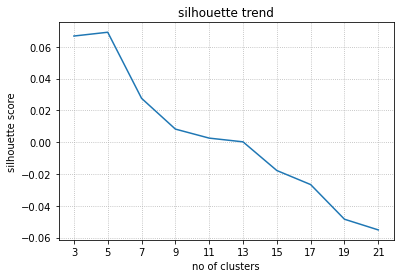

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

#Plot a graph for different values of k and their Silhouette scores.
plt.plot(k_values, s_scores)
plt.xticks(k_values, k_values)
plt.xlabel('no of clusters')
plt.ylabel('silhouette score')
plt.title('silhouette trend')
plt.grid(linestyle='dotted')

plt.savefig('plot.png')
plt.show()